The **FIFA World Cup**, often simply called the World Cup, is an international association football competition contested by the senior men's national teams of the members of the Fédération Internationale de Football Association (FIFA), the sport's global governing body. The championship has been awarded **every four years** since the inaugural tournament in 1930, except in 1942 and 1946 when it was not held because of the Second World War.

The current format of the competition involves a **qualification phase, which currently takes place over the preceding three years**, to determine which teams qualify for the tournament phase, which is often called the World Cup Finals. After this, **32 teams, including the automatically qualifying host nation(s)**, compete in the tournament phase for the title at venues within the host nation(s) over a period of about a month.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import itertools
import warnings

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 700)
warnings.filterwarnings('ignore')

# 1. Importing Data and Data Exploration

In [3]:
wc = pd.read_csv('data/results.csv')
fifa = pd.read_csv('data/fifa_ranking.csv')
confed = fifa[['country_full', 'confederation']].groupby('country_full').max()
wc['date'] = pd.to_datetime(wc['date'], infer_datetime_format=True)
wc.rename(columns={'country': 'host_country', 'neutral': 'neutral_site'}, inplace=True)

# we're only insterested in analysing FIFA World Cup related games
wc = wc[wc['tournament'].str.contains('FIFA')]

# the current tournament format with 32 teams has been used since 1998
wc = wc[(wc['date'].dt.year >= 1995) & (wc['date'].dt.year <= 2018)]
wc.reset_index(drop=True, inplace=True)

In [4]:
fifa

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57577,207,Anguilla,AIA,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-05-17
57578,207,Bahamas,BAH,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-05-17
57579,207,Eritrea,ERI,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-05-17
57580,207,Somalia,SOM,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-05-17


In [5]:
wc.shape

(5002, 9)

In [6]:
display(wc.head())
display(wc.tail())

,date,home_team,away_team,home_score,away_score,tournament,city,host_country,neutral_site
0,1996-03-10,Dominica,Antigua and Barbuda,3,3,FIFA World Cup qualification,Roseau,Dominica,False
1,1996-03-24,Dominican Republic,Aruba,3,2,FIFA World Cup qualification,Santo Domingo,Dominican Republic,False
2,1996-03-29,Guyana,Grenada,1,2,FIFA World Cup qualification,Georgetown,Guyana,False
3,1996-03-31,Antigua and Barbuda,Dominica,1,3,FIFA World Cup qualification,St. John's,Antigua and Barbuda,False
4,1996-03-31,Aruba,Dominican Republic,1,3,FIFA World Cup qualification,Oranjestad,Aruba,False


,date,home_team,away_team,home_score,away_score,tournament,city,host_country,neutral_site
4997,2018-07-07,Russia,Croatia,2,2,FIFA World Cup,Sochi,Russia,False
4998,2018-07-10,France,Belgium,1,0,FIFA World Cup,St. Petersburg,Russia,True
4999,2018-07-11,Croatia,England,2,1,FIFA World Cup,Moscow,Russia,True
5000,2018-07-14,Belgium,England,2,0,FIFA World Cup,St. Petersburg,Russia,True
5001,2018-07-15,France,Croatia,4,2,FIFA World Cup,Moscow,Russia,True


In [7]:
wc.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002 entries, 0 to 5001
Data columns (total 9 columns):
date            5002 non-null datetime64[ns]
home_team       5002 non-null object
away_team       5002 non-null object
home_score      5002 non-null int64
away_score      5002 non-null int64
tournament      5002 non-null object
city            5002 non-null object
host_country    5002 non-null object
neutral_site    5002 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 317.6+ KB


In [8]:
wc.describe() # we can see a slight difference at the average home_score and average away score
              # however, it is clear that it is statistically insignificant

,home_score,away_score
count,5002.000000,5002.000000
mean,1.749500,1.106357
std,1.853952,1.379820
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,17.000000


In [9]:
fifa[(fifa['country_full'] == 'Serbia') | (fifa['country_full'] == 'Serbia and Montenegro')].sort_values('rank_date')

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
19387,19,Serbia and Montenegro,SCG,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2002-12-18
19590,19,Serbia and Montenegro,SCG,0.00,678,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-01-15
19795,19,Serbia and Montenegro,SCG,0.00,677,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-02-19
20001,20,Serbia and Montenegro,SCG,0.00,674,-1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-03-26
20207,22,Serbia and Montenegro,SCG,0.00,667,-2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-04-23
20411,22,Serbia and Montenegro,SCG,0.00,659,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-05-21
20620,27,Serbia and Montenegro,SCG,0.00,650,-5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-06-25
20830,33,Serbia and Montenegro,SCG,0.00,636,-6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-07-30
21032,29,Serbia and Montenegro,SCG,0.00,621,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-08-27
21240,35,Serbia and Montenegro,SCG,0.00,621,-6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,2003-09-24


# 2. Data Wrangling and Feature Engineering

In [10]:
# we're only interested in games related to each WC edition
years = wc['date'].dt.year.copy()
wc_years = [1994, 1998, 2002, 2006, 2010, 2014]
for y in wc_years:
    years.mask((y < years) & (years < y + 4), y + 4, inplace=True)

        
# revamping the tournament feature so that each game is labeled according to its WC edition
wc['tournament'] = (wc['tournament']
                    .map({'FIFA World Cup qualification': 'WC_q', 'FIFA World Cup': 'WC'})
                    .str.cat(years.astype('str'), sep=' '))


# creating a "stage" feature representing at which stage of the competition the game occurred
stage = np.empty(0, dtype=object)
for y in range(6):
    new_stage = np.empty(64, dtype=object)
    new_stage[0:48] = 'G' # group stage
    new_stage[48:56] = 'R16' # round of 16
    new_stage[56:60] = 'QF' # quarter-finals
    new_stage[60:62] = 'SF' # semi-finals
    new_stage[62:63] = 'LF' # losers finals
    new_stage[63:64] = 'WF' # winners finals
    stage = np.concatenate((stage, new_stage), axis = 0)

wc['stage'] = ['Quals'] * len(wc) # qualifications
wc_mask = wc['tournament'].str.contains(r'WC \d{4}', regex=True)
wc.loc[wc_mask, 'stage'] = stage


# creating a "winner" feature, labeled according to the winner of the game
wc['winner'] = [None] * len(wc)
wc['winner'] = ((wc['home_score'] > wc['away_score']) * wc['home_team'] +
                (wc['home_score'] < wc['away_score']) * wc['away_team'])


# creating a "agg_score" feature
wc['agg_score'] = wc['home_score'] + wc['away_score']


# most tie games had no winners; only those in the knockout stage of a WC had a winner decided by a penalty shoot-out
winners_idx = [686, 689, 692, 1512, 1520, 2415, 2418, 2421, 2425, 3276, 
               3279, 4124, 4126, 4135, 4137, 4988, 4989, 4993, 4997]
winners = ['Argentina', 'France', 'Brazil', 'Spain', 'South Korea', 'Ukraine', 'Germany', 'Portugal', 'Italy', 'Paraguay', 
           'Uruguay', 'Brazil', 'Costa Rica', 'Netherlands', 'Argentina', 'Russia', 'Croatia', 'England', 'Croatia']
wc['winner'].iloc[winners_idx] = winners


# cleaning the tournament feature labels
wc.loc[wc['tournament'].str.contains(r'WC_q \d{4}', regex=True), 'tournament'] = \
wc.loc[wc['tournament'].str.contains(r'WC_q \d{4}', regex=True), 'tournament'].str.split('_q').str.join('')


# dropping unnecessary features and rearranging the dataframe
wc.drop(['date', 'city'], axis=1, inplace=True)
wc = wc[['host_country', 'tournament', 'stage', 'home_team', 'home_score', 
         'away_team', 'away_score', 'agg_score', 'winner', 'neutral_site']]

In [11]:
# appending to the dataframes the confederations to which each team belongs
countries = wc['home_team'].unique()
s = confed.loc[countries].sort_index()
wc['confederation'] = wc['home_team'].map(dict(s['confederation']))
    
    
# filling in some missing values
confederations = ['UEFA', 'CONMEBOL', 'CONCACAF', 'CAF', 'AFC', 'OFC']
missing_conf = list(wc.loc[wc['confederation'].isna(), 'home_team'])

missing_conf = sorted(list(set(missing_conf)))
found_conf = ['AFC', 'AFC', 'CAF', 'CAF', 'AFC', 'CAF', 'AFC', 'CAF', 'AFC', 'AFC', 'UEFA', \
              'CONCACAF', 'CONCACAF', 'CONCACAF', 'AFC', 'CAF', 'CONCACAF', 'CONCACAF']
miss_mapping = dict(zip(missing_conf, found_conf))

wc.loc[wc['confederation'].isna(), 'confederation'] = wc.loc[wc['confederation'].isna(), 'home_team'].map(miss_mapping)

# Country names by FIFA:
# Brunei = Brunei Darussalam
# Burma = Myanmar
# Cape Verde = Cape Verde Islands
# DR Congo = Congo DR
# East Timor = Timor-Leste
# Eswatini = Swaziland
# Iran = IR Iran
# Ivory Coast = Côte d'Ivoire
# Kyrgyzstan = Kyrgyz Republic
# North Korea = Korea DPR
# North Macedonia = FYR Macedonia
# Saint Kitts and Nevis = St Kitts and Nevis
# Saint Lucia = St Lucia
# Saint Vincent and the Grenadines = St Vincent and the Grenadines
# South Korea = Korea Republic
# São Tomé and Príncipe = São Tomé e Príncipe
# U.S. Virgin Islands = US Virgin Islands
# United States = USA

fifa_list = ['USA', 'US Virgin Islands', 'São Tomé e Príncipe', 'Korea Republic', 'St Vincent and the Grenadines',\
             'St Lucia', 'St Kitts and Nevis', 'FYR Macedonia', 'Korea DPR', 'Kyrgyz Republic', "Côte d'Ivoire",\
             'IR Iran', 'Swaziland', 'Timor-Leste', 'Congo DR', 'Cape Verde Islands', 'Myanmar', 'Brunei Darussalam']

mapping_fifa = {'USA': 'United States', 'US Virgin Islands': 'U.S. Virgin Islands',\
                'São Tomé e Príncipe': 'São Tomé and Príncipe', 'Korea Republic': 'South Korea',\
                'St Vincent and the Grenadines': 'Saint Vincent and the Grenadines', 'St Lucia': 'Saint Lucia',\
                'St Kitts and Nevis': 'Saint Kitts and Nevis', 'FYR Macedonia': 'North Macedonia',\
                'Korea DPR': 'North Korea', 'Kyrgyz Republic': 'Kyrgyzstan', "Côte d'Ivoire": 'Ivory Coast',\
                'IR Iran': 'Iran', 'Swaziland': 'Eswatini', 'Timor-Leste': 'East Timor', 'Congo DR': 'DR Congo',\
                'Cape Verde Islands': 'Cape Verde', 'Myanmar': 'Burma', 'Brunei Darussalam': 'Brunei'}

In [12]:
wc_1998_tourn = (wc[(wc['tournament'] == 'WC 1998') & (wc['stage'] != 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2002_tourn = (wc[(wc['tournament'] == 'WC 2002') & (wc['stage'] != 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2006_tourn = (wc[(wc['tournament'] == 'WC 2006') & (wc['stage'] != 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2010_tourn = (wc[(wc['tournament'] == 'WC 2010') & (wc['stage'] != 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2014_tourn = (wc[(wc['tournament'] == 'WC 2014') & (wc['stage'] != 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2018_tourn = (wc[(wc['tournament'] == 'WC 2018') & (wc['stage'] != 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))

editions = ['1998 WC France', '2002 WC South Korea-Japan', '2006 WC Germany',\
       '2010 WC South Africa', '2014 WC Brazil', '2018 WC Russia']
tourns_df = pd.concat([wc_1998_tourn, wc_2002_tourn, wc_2006_tourn,\
                wc_2010_tourn, wc_2014_tourn, wc_2018_tourn], axis=1, keys=editions)

# 3. Data Analysis and Visualization

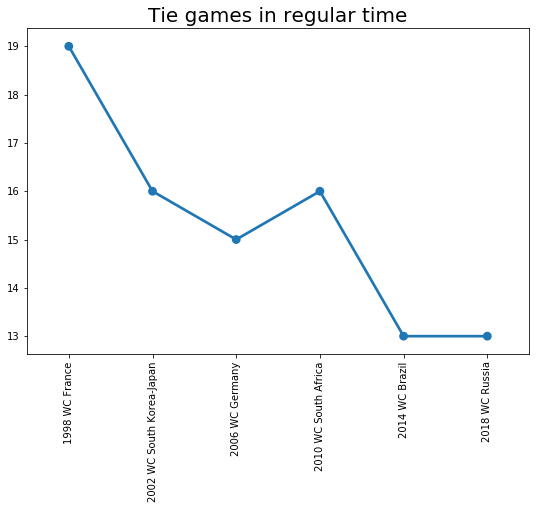

In [13]:
# has the level playing field become more even with time?
draws = {ed: (tourns_df[ed]['home_score'] == tourns_df[ed]['away_score']).sum() for ed in editions}
df = pd.DataFrame(draws, index=['tie games']).T
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.pointplot(x=df.index, y='tie games', data=df)
plt.title('Tie games in regular time', fontsize=20)
ax.set_ylabel('')
plt.xticks(rotation='vertical');

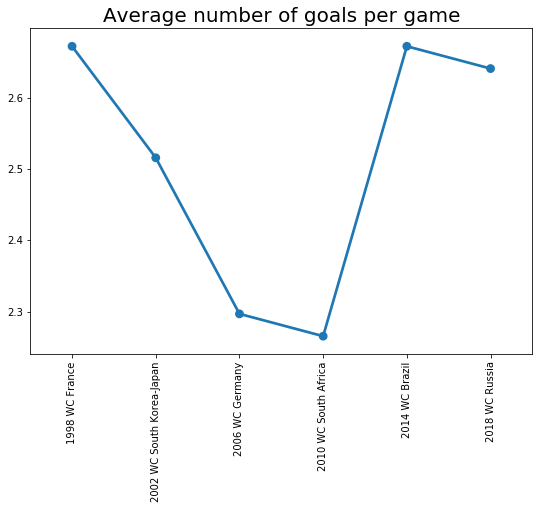

In [14]:
# average number of goals per game
avg_goals = {ed: (tourns_df[ed]['agg_score']).mean() for ed in editions}
df = pd.DataFrame(avg_goals, index=['avg goals']).T
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.pointplot(x=df.index, y='avg goals', data=df)
plt.title('Average number of goals per game', fontsize=20)
ax.set_ylabel('')
plt.xticks(rotation='vertical');

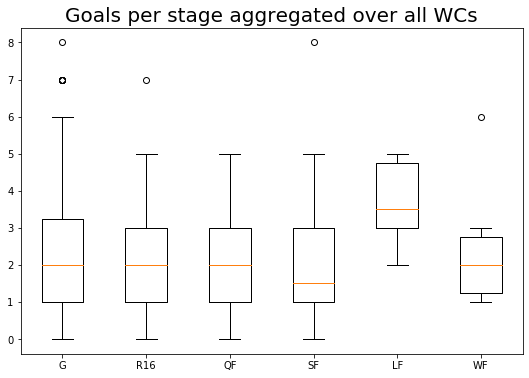

In [15]:
df = pd.concat([wc_1998_tourn[['stage', 'agg_score']], wc_2002_tourn[['stage', 'agg_score']],\
                wc_2006_tourn[['stage', 'agg_score']], wc_2010_tourn[['stage', 'agg_score']],\
                wc_2014_tourn[['stage', 'agg_score']], wc_2018_tourn[['stage', 'agg_score']]],\
                axis=0, ignore_index=True)

df_G = df[df['stage'] =='G']
df_R16 = df[df['stage'] =='R16']
df_QF = df[df['stage'] =='QF']
df_SF = df[df['stage'] =='SF']
df_LF = df[df['stage'] =='LF']
df_WF = df[df['stage'] =='WF']

data = [df_G['agg_score'], df_R16['agg_score'], df_QF['agg_score'], \
        df_SF['agg_score'], df_LF['agg_score'], df_WF['agg_score']]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.title('Goals per stage aggregated over all WCs', fontsize=20)
ax.boxplot(data)
ax.set_xticklabels(['G', 'R16', 'QF', 'SF', 'LF', 'WF']);

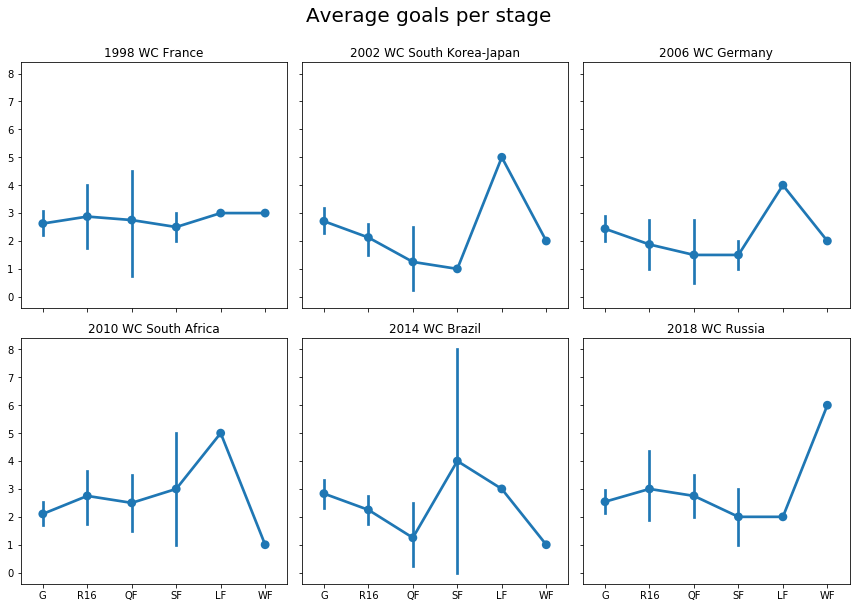

In [16]:
# are teams more cautious in later-stage games, leading to fewer goals on average?
stages = ['G', 'R16', 'QF', 'SF', 'LF', 'WF']

df = pd.concat([wc_1998_tourn[['stage', 'agg_score']], wc_2002_tourn[['stage', 'agg_score']],\
                wc_2006_tourn[['stage', 'agg_score']], wc_2010_tourn[['stage', 'agg_score']],\
                wc_2014_tourn[['stage', 'agg_score']], wc_2018_tourn[['stage', 'agg_score']]],\
                axis=1, keys=editions)

pairs = list(itertools.product(range(2), range(3)))
fig, ax = plt.subplots(2, 3, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('Average goals per stage', y=1.05, fontsize=20)
for i, (j, k) in enumerate(pairs):
    ax[j, k].set_title(editions[i])
    sns.pointplot(df[editions[i]]['stage'], df[editions[i]]['agg_score'], ax=ax[j, k], ci=95, xlabel='')
    ax[j, k].set_xlabel('')
    ax[j, k].set_ylabel('')
plt.tight_layout()

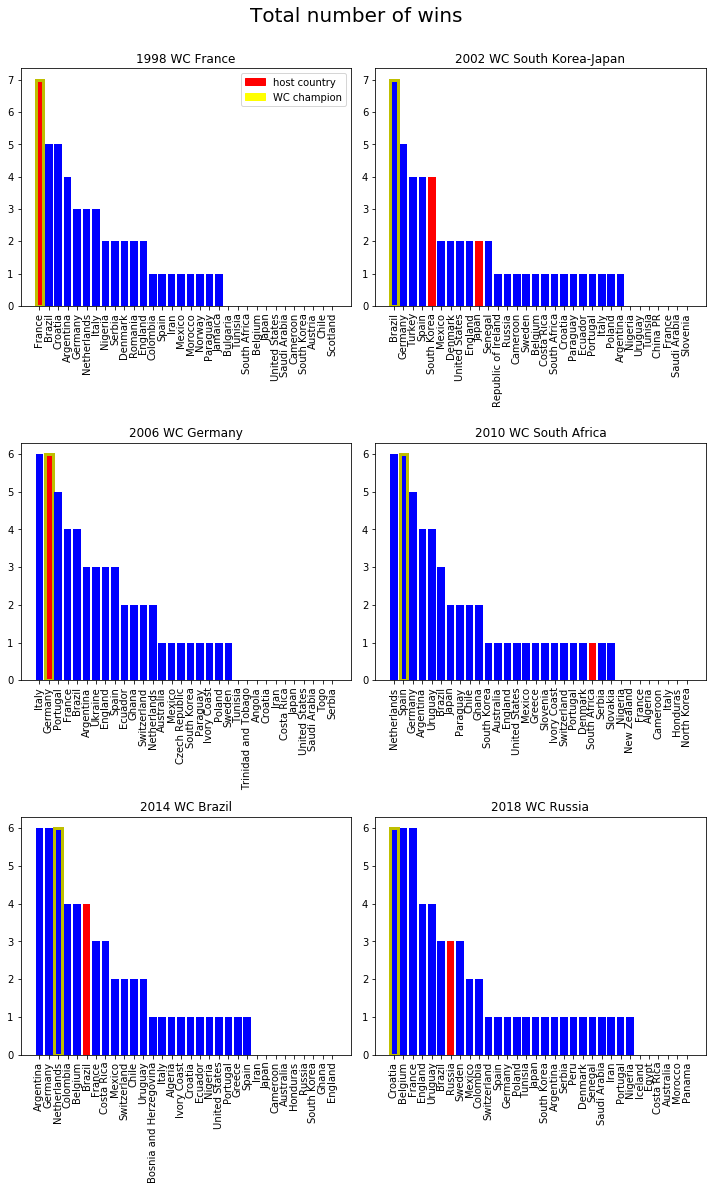

In [17]:
# is home-field advantage real?
wins_per_wc = {ed: tourns_df[ed].loc[tourns_df[ed]['winner'] != '', 'winner'].value_counts() for ed in editions}

for ed in editions:
    teams = set(tourns_df[ed][['home_team', 'away_team']].stack())
    no_wins = list(teams.difference(set(wins_per_wc[ed].index)))
    zeros = [0] * len(no_wins)
    s = pd.Series(zeros, no_wins)
    wins_per_wc[ed] = pd.concat([wins_per_wc[ed], s], axis=0)

host_country = ['France', 'South Korea-Japan', 'Germany', 'South Africa', 'Brazil', 'Russia']
colors = [None] * 6
for idx, ed in enumerate(editions):
    hc = host_country[idx]
    colors[idx] = ['r' if country in hc.split('-') else 'b' for country in wins_per_wc[ed].index]

wc_champs = [0, 0, 1, 1, 2, 0]
    
pairs = list(itertools.product(range(3), range(2)))
fig, ax = plt.subplots(3, 2, figsize=(10, 16))
fig.suptitle('Total number of wins', fontsize=20, y=1.03)
for i, (j, k) in enumerate(pairs):
    ax[j, k].set_title(editions[i])
    bars = ax[j, k].bar(wins_per_wc[editions[i]].index, wins_per_wc[editions[i]].values, color=colors[i])
    bars[wc_champs[i]].set_edgecolor('y')
    bars[wc_champs[i]].set_linewidth(3)
    for tick in ax[j, k].get_xticklabels():
        tick.set_rotation('vertical')
red_patch = mpatches.Patch(color='red', label='host country')
yellow_patch = mpatches.Patch(color='yellow', label='WC champion')
ax[0, 0].legend(handles=[red_patch, yellow_patch], loc='upper right')
plt.tight_layout()

In [18]:
wc_1998_quals = (wc[(wc['tournament'] == 'WC 1998') & (wc['stage'] == 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2002_quals = (wc[(wc['tournament'] == 'WC 2002') & (wc['stage'] == 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2006_quals = (wc[(wc['tournament'] == 'WC 2006') & (wc['stage'] == 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2010_quals = (wc[(wc['tournament'] == 'WC 2010') & (wc['stage'] == 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2014_quals = (wc[(wc['tournament'] == 'WC 2014') & (wc['stage'] == 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))
wc_2018_quals = (wc[(wc['tournament'] == 'WC 2018') & (wc['stage'] == 'Quals')]
                 .reset_index(drop=True)
                 .drop(['host_country', 'tournament'], axis=1))

quals = [wc_1998_quals, wc_2002_quals, wc_2006_quals, wc_2010_quals, wc_2014_quals, wc_2018_quals]
quals_dict = dict(zip(editions, quals))

In [19]:
# countries that got direct entry to the WC:
direct_entry = {'1998 WC France': 
                    {'countries': ['France', 'Brazil'],
                     'confeds': {'France': 'UEFA', 'Brazil': 'CONMEBOL'}},
                '2002 WC South Korea-Japan':
                    {'countries': ['South Korea', 'Japan', 'France'],
                     'confeds': {'South Korea': 'AFC', 'Japan': 'AFC', 'France': 'UEFA'}},
                '2006 WC Germany': 
                    {'countries': ['Germany'],
                     'confeds': {'Germany': 'UEFA'}},
                '2010 WC South Africa':
                    {'countries': ['South Africa'],
                     'confeds': {'South Africa': 'CAF'}}, # yet, they still participated in the 2010 WC CAF qualifiers
                '2014 WC Brazil':                         # however, this won't be considered, since is an anomaly
                    {'countries': ['Brazil'],
                     'confeds': {'Brazil': 'CONMEBOL'}},
                '2018 WC Russia':
                    {'countries': ['Russia'],
                     'confeds': {'Russia': 'UEFA'}}}

# total number of points each team made in the qualification stage to the WC
quals_info = {}
for ed in editions:
    teams = sorted(tourns_df[ed][['home_team', 'away_team']].stack().unique())
    quals_info[ed] = {}
    for c in teams:
        df = quals_dict[ed][(quals_dict[ed]['home_team'] == c) | (quals_dict[ed]['away_team'] == c)]
        if c in direct_entry[ed]['countries']:
            qual_pts = np.nan
            confederation = direct_entry[ed]['confeds'][c]
        else:
            qual_pts = df['winner'].tolist().count(c) * 3 + df['winner'].tolist().count('')
            confederation = df['confederation'].iloc[0]
        quals_info[ed][c] = [qual_pts, confederation]

In [20]:
# label encoding the stage feature
mapping_stage = {'G': 0, 'R16': 1, 'QF': 2, 'SF': 3, 'LF': 4, 'WF': 5}
df = []
for ed in editions:
    df.append(tourns_df[ed].join(tourns_df[ed]['stage'].map(mapping_stage), rsuffix='_enc').drop('stage', axis=1))

tourns_df = pd.concat(df, axis=1, keys=editions)

# furthest stage reached in the WC
wc_champions = dict(zip(editions, ['France', 'Brazil', 'Italy', 'Spain', 'Germany', 'France']))
furthest_stage = {}
for ed in editions:
    furthest_stage[ed] = {}
    for c, v in quals_info[ed].items():
        s = (tourns_df[ed]['home_team'] == c) | (tourns_df[ed]['away_team'] == c)
        furthest_stage[ed][c] = tourns_df[ed].loc[s[s==True].index[-1], 'stage_enc']
        if c == wc_champions[ed]:
            furthest_stage[ed][c] += 1

In [21]:
data = {}
for ed in editions:
    df_1 = pd.DataFrame(furthest_stage[ed], index=['furthest_stage']).T
    df_2 = pd.DataFrame(quals_info[ed], index=['qual_pts', 'confederation']).T
    data[ed] = pd.concat([df_1, df_2], axis=1)

In [22]:
# a statistic that aims at measuring how good the confederations' teams perform on the WCs on average
confed_metrics = pd.Series()
for ed in editions:
    confed_metrics[ed] = data[ed].groupby('confederation')['furthest_stage'].mean()
    data[ed]['confed_metrics'] = data[ed]['confederation'].map(confed_metrics[ed])

In [23]:
# calculating the total number of appearances in WCs up until, and including, that edition
n_appearances = pd.DataFrame()
for i, ed in enumerate(editions):
    df = pd.DataFrame(index=data[ed].index, data=[1]*len(data[ed].index), columns=[ed])
    n_appearances = n_appearances.merge(df, left_index=True, right_index=True, how='outer')
    n_appearances.fillna(0, inplace=True)
    try:
        n_appearances[editions[i]] += n_appearances[editions[i - 1]]
    except:
        pass
    
for ed in editions:
    data[ed]['n_appearances'] = n_appearances[ed].loc[data[ed].index]

In [26]:
rankings = fifa[['rank', 'country_full', 'rank_date', 'confederation']]
rankings.columns = ['rank', 'country', 'date', 'confederation']
rankings['date'] = pd.to_datetime(rankings['date'], infer_datetime_format=True)
rankings = rankings[rankings['date'] >= '1996-03-10']
rankings['date'] = rankings['date'].dt.year

years = rankings['date']
wc_years = [1994, 1998, 2002, 2006, 2010, 2014]
for y in wc_years:
    years.mask((y < years) & (years < y + 4), y + 4, inplace=True)
    
rank_df = rankings.groupby(['country', 'date', 'confederation']).mean()
rank_df.reset_index(inplace=True)
rank_df.sort_values(['country', 'date'], inplace=True)
rank_df.rename(columns={'rank': 'avg_rank'}, inplace=True)
rank_df = rank_df[rank_df['country'].isin(n_appearances.index)].reset_index(drop=True)


rank_df = pd.pivot_table(rank_df, index=['confederation', 'country'], columns='date', values='avg_rank').reset_index(level='confederation')
rank_df.columns.name = None
rank_df.index.name = None
rank_df.columns = ['confederation', 'avg_rank_1998', 'avg_rank_2002', 'avg_rank_2006', 'avg_rank_2010', 'avg_rank_2014', 'avg_rank_2018']

In [31]:
median_uefa = {}
median_uefa['avg_rank_1998'] = (rank_df.loc[rank_df['confederation'] == 'UEFA', 'avg_rank_1998']
                                .median(axis=0, skipna=True))
median_uefa['avg_rank_2002'] = (rank_df.loc[rank_df['confederation'] == 'UEFA', 'avg_rank_2002']
                                .median(axis=0, skipna=True))

rank_df.loc['Serbia', 'avg_rank_1998'] = median_uefa['avg_rank_1998']
rank_df.loc['Serbia', 'avg_rank_2002'] = median_uefa['avg_rank_2002']

rank_df

,confederation,avg_rank_1998,avg_rank_2002,avg_rank_2006,avg_rank_2010,avg_rank_2014,avg_rank_2018
Australia,AFC,39.428571,62.297872,56.127660,32.659574,41.937500,53.000000
China PR,AFC,57.535714,62.404255,68.446809,88.468085,85.145833,79.097561
Japan,AFC,19.285714,39.765957,24.212766,37.191489,31.291667,51.878049
Saudi Arabia,AFC,34.464286,37.553191,36.808511,59.170213,94.666667,69.390244
Algeria,CAF,54.892857,76.787234,71.702128,61.106383,31.895833,39.146341
Angola,CAF,62.678571,56.382979,72.170213,75.680851,89.458333,122.024390
Cameroon,CAF,45.178571,36.276596,17.446809,20.340426,55.104167,48.902439
Egypt,CAF,27.571429,36.553191,31.553191,26.829787,44.208333,42.073171
Ghana,CAF,41.821429,53.787234,63.617021,28.127660,27.812500,40.902439
Morocco,CAF,20.035714,28.553191,35.489362,52.574468,71.750000,63.658537


In [ ]:
for i, ed in enumerate(editions):
    data[ed] = pd.merge(data[ed], rank_df.iloc[:, 0:i+1], left_index=True, right_index=True, how='left')

In [ ]:
# let's fill in the missing values for Serbia with the median of the corresponding confederation
median_uefa = {}
for i, ed in enumerate(editions):
    median_uefa[ed] = data[ed][data[ed]['confederation'] == 'UEFA'].iloc[:, 5:6+i].median(axis=0, skipna=True)
    
data[editions[0]].loc['Serbia', 'avg_rank_1998'] = median_uefa[editions[0]].values
data[editions[2]].loc['Serbia', ['avg_rank_1998', 'avg_rank_2002']] =\
[median_uefa[editions[2]].values[0], median_uefa[editions[2]].values[1]]
data[editions[3]].loc['Serbia', ['avg_rank_1998', 'avg_rank_2002']] =\
[median_uefa[editions[3]].values[0], median_uefa[editions[3]].values[1]]
data[editions[5]].loc['Serbia', ['avg_rank_1998', 'avg_rank_2002']] =\
[median_uefa[editions[5]].values[0], median_uefa[editions[5]].values[1]]

In [ ]:
# let's fill in the missing values for host coutries and former champions with the median of the corresponding confederation
median_bra_98 = data[editions[0]][data[editions[0]]['confederation'] == 'CONMEBOL'].median(axis=0, skipna=True)['qual_pts']
median_fra_98 = data[editions[0]][data[editions[0]]['confederation'] == 'UEFA'].median(axis=0, skipna=True)['qual_pts']
median_fra_02 = data[editions[1]][data[editions[1]]['confederation'] == 'UEFA'].median(axis=0, skipna=True)['qual_pts']
median_jpn_02 = data[editions[1]][data[editions[1]]['confederation'] == 'AFC'].median(axis=0, skipna=True)['qual_pts']
median_kor_02 = median_jpn_02
median_ger_06 = data[editions[2]][data[editions[2]]['confederation'] == 'UEFA'].median(axis=0, skipna=True)['qual_pts']
median_afr_10 = data[editions[3]][data[editions[3]]['confederation'] == 'CAF'].median(axis=0, skipna=True)['qual_pts']
median_bra_14 = data[editions[4]][data[editions[4]]['confederation'] == 'CONMEBOL'].median(axis=0, skipna=True)['qual_pts']
median_rus_18 = data[editions[5]][data[editions[5]]['confederation'] == 'UEFA'].median(axis=0, skipna=True)['qual_pts']

In [ ]:
data[editions[0]].loc[['Brazil', 'France'], 'qual_pts'] = [median_bra_98, median_fra_98]
data[editions[1]].loc[['France', 'Japan', 'South Korea'], 'qual_pts'] = [median_fra_02, median_jpn_02, median_kor_02]
data[editions[2]].loc['Germany', 'qual_pts'] = median_ger_06
data[editions[3]].loc['South Africa', 'qual_pts'] = median_afr_10
data[editions[4]].loc['Brazil', 'qual_pts'] = median_bra_14
data[editions[5]].loc['Russia', 'qual_pts'] = median_rus_18

In [ ]:
corr_data = data[editions[5]].corr()

fig, ax = plt.subplots(figsize=(8,8))

mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_data, mask=mask, cmap='Blues', annot=True, square=True, cbar_kws={"shrink": .75})
ax.set_ylim(len(corr_data), 0, 0);

# 4. Data Reporting

In [ ]:
X = data[editions[4]].drop(['furthest_stage', 'confederation'], axis=1)
y = data[editions[4]]['furthest_stage']
lm = LinearRegression()
lm.fit(X, y)
lm.score(X, y)

In [ ]:
X_pred = data[editions[5]].drop(['furthest_stage', 'confederation'], axis=1)
pred = pd.Series(lm.predict(X_pred), index=y.index)
# table = pd.concat([y, pred], axis=1).reset_index()
# table.columns = ['country', 'actual', 'pred']
# table = table.sort_values(by='pred').reset_index(drop=True)
# table['ranked_pred'] = [0] * 32
# table.loc[16:23, 'ranked_pred'] = 1
# table.loc[24:27, 'ranked_pred'] = 2
# table.loc[28:29, 'ranked_pred'] = 4
# table.loc[30, 'ranked_pred'] = 5
# table.loc[31, 'ranked_pred'] = 6
# table['sq_diff'] = (table['actual'] - table['ranked_pred']) ** 2
# rmse = np.mean(table['sq_diff']) ** 0.5
# rmse